In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Flatten
%matplotlib inline

In [2]:
df=pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv',delimiter=',',encoding='latin-1')

In [3]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [4]:
# drop unuse columns
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [5]:
# rename columns
df.rename(columns={'v1':'target','v2':'sms'},inplace=True)

## LabelEncoding Target Column

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
le=LabelEncoder()

In [8]:
df['target']=le.fit_transform(df['target'])

## train_test_split

In [9]:
x=df['sms']
y=df['target']

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=20)

## Process train dataset

num_word = the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.

maxlen = Optional Int, maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence.

Tokenizer = Tokenize the data and convert the text to sequences.

padding = String, 'pre' or 'post' (optional, defaults to 'pre'): pad either before or after each sequence.

pad_sequences = Add padding to ensure that all the sequences have the same shape

In [11]:
max_words=1000
max_len=172
token=Tokenizer(num_words=max_words)
token.fit_on_texts(df['sms'])
sequences=token.texts_to_sequences(x_train)
sequences_metrix=sequence.pad_sequences(sequences,padding='post',maxlen=max_len)

## Process test dataset

In [12]:
# process test data
test_sequences = token.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,padding='post',maxlen=max_len)

## define model

In [13]:
model=Sequential()

# embedding layer
model.add(Embedding(max_words,50,input_length=max_len,trainable=True))

# lstm layer
model.add(LSTM(100,return_sequences=True,dropout=0.5))
model.add(Flatten()) 
# Dense layer
model.add(Dense(200,activation='relu',name='hl1')) # hidden layer 1
model.add(Dense(100,activation='relu',name='hl2')) # hidden layer 2
model.add(Dense(1,activation='sigmoid',name='ol')) # output layer


    
# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])

# Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1,patience=3)

model.summary()

2021-11-21 04:32:22.883873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 04:32:23.026492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 04:32:23.027724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-21 04:32:23.029501: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 172, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 172, 100)          60400     
_________________________________________________________________
flatten (Flatten)            (None, 17200)             0         
_________________________________________________________________
hl1 (Dense)                  (None, 200)               3440200   
_________________________________________________________________
hl2 (Dense)                  (None, 100)               20100     
_________________________________________________________________
ol (Dense)                   (None, 1)                 101       
Total params: 3,570,801
Trainable params: 3,570,801
Non-trainable params: 0
______________________________________________

In [14]:
sequences_metrix.shape,y_train.shape # shape of train dataset

((4457, 172), (4457,))

In [15]:
test_sequences_matrix.shape,y_test.shape # shape of test dataset

((1115, 172), (1115,))

## Train model

In [16]:
# Train model
history=model.fit(sequences_metrix,y_train,batch_size=150,epochs=20,callbacks=[es],validation_split=0.2,verbose=1)

Epoch 1/20


2021-11-21 04:32:26.052314: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-21 04:32:28.982958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


24/24 [==============================] - 5s 43ms/step - loss: 0.3620 - accuracy: 0.8541 - val_loss: 0.2075 - val_accuracy: 0.8655
Epoch 2/20
24/24 [==============================] - 1s 24ms/step - loss: 0.1279 - accuracy: 0.9560 - val_loss: 0.0590 - val_accuracy: 0.9854
Epoch 3/20
24/24 [==============================] - 1s 23ms/step - loss: 0.0546 - accuracy: 0.9865 - val_loss: 0.0574 - val_accuracy: 0.9854
Epoch 4/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0370 - accuracy: 0.9877 - val_loss: 0.0469 - val_accuracy: 0.9899
Epoch 5/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0286 - accuracy: 0.9899 - val_loss: 0.0522 - val_accuracy: 0.9910
Epoch 6/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0213 - accuracy: 0.9938 - val_loss: 0.0486 - val_accuracy: 0.9899
Epoch 7/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0159 - accuracy: 0.9955 - val_loss: 0.0498 - val_accuracy: 0.9910
Epoch 00007: early stopp

## Evaluation model

In [17]:
# evaluation model
train_acc=model.evaluate(sequences_metrix,y_train,verbose=1) # train dataset evaluate
test_acc=model.evaluate(test_sequences_matrix,y_test,verbose=1) # test dataset evaluate

35/35 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.9883


In [18]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(train_acc[0],train_acc[1])) # train dataset Loss and Accurancy

Loss:0.017 and Accuracy:0.997


In [19]:
print("Loss:{:.3f} and Accuracy:{:.3f}".format(test_acc[0],test_acc[1])) # test dataset Loss and Accurancy

Loss:0.068 and Accuracy:0.988


## plot training history

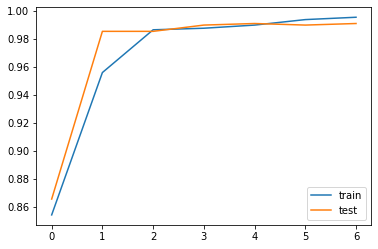

In [20]:
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()